In [1]:
import cv2
import numpy as np
import pandas as pd
import importlib
import cryptosystem
import crypt_anlaysis
import differential_attack_analysis
import os
import time

In [2]:
importlib.reload(cryptosystem)
importlib.reload(crypt_anlaysis)
importlib.reload(differential_attack_analysis)
from cryptosystem import Cryptosystem, Encryption, Decryption
from crypt_anlaysis import experimentalAnalysis
from differential_attack_analysis import npcr,uaci

In [3]:
time_file = './outputs/time_complexity.csv'
time_records=[]
if os.path.exists(time_file):
    time_df = pd.read_csv(time_file)
else:
    # If file doesn't exist, create an empty DataFrame
    time_df = pd.DataFrame()

In [4]:
image = cv2.imread('images/fruits.jpg')
image_name = "fruits"

In [5]:
x = Cryptosystem(image)

m,n: 256 256


In [6]:
key="101011111100110101000001010010110101101101010010100101010100011011001110110110010101111110010110000100010101000011000101100011011011111110011001111110101111111101001001111100111010101110000010000011101100100110000100000111101000100010101101"

In [7]:
a1,b1,x0,y0 = x.generateInitials(key)
print(a1,b1,x0,y0)

18.283025877973234 17.694797580802135 0.6563416916515812 -0.8429732659873648


In [8]:
map1 = x.getChaoticMap(a1,b1,x0,y0)
map2 = x.getChaoticMap(a1,b1,map1[len(map1)-1][0],map1[len(map1)-1][1]) # map2 x0,y0 from the last values of map1 as given in paper
map3 = x.getChaoticMap(a1,b1,map2[len(map2)-1][0],map2[len(map2)-1][1])
map4 = x.getChaoticMap(a1,b1,map3[len(map3)-1][0],map3[len(map3)-1][1])
map5 = x.getChaoticMap(a1,b1,map4[len(map4)-1][0],map4[len(map4)-1][1])
map6 = x.getChaoticMap(a1,b1,map5[len(map5)-1][0],map5[len(map5)-1][1])


In [9]:
rm1 = x.getRuleMap(map2,8)
rm2 = x.getRuleMap(map3,8)
rm3 = x.getRuleMap(map5,8)
rm4 = x.getRuleMap(map6,8)

No of times rule present in rule map
{1: 29440, 2: 32768, 3: 34560, 4: 32512, 5: 31232, 6: 38656, 7: 33792, 8: 29184}
No of times rule present in rule map
{1: 36608, 2: 36608, 3: 34816, 4: 29440, 5: 32256, 6: 33280, 7: 30464, 8: 28672}
No of times rule present in rule map
{1: 32768, 2: 34048, 3: 32768, 4: 33536, 5: 34048, 6: 32768, 7: 31744, 8: 30464}
No of times rule present in rule map
{1: 33536, 2: 38656, 3: 26624, 4: 33024, 5: 32768, 6: 31488, 7: 30976, 8: 35072}


In [10]:
dsm = x.getDSMMap(map4,rm2)

No of times Neucleotides present in DSMap
{'A': 65020, 'T': 59422, 'G': 69882, 'C': 67820}


In [11]:
IVf= x.getfloorIV(8,map1)

In [12]:
def save_inter_image(image_name,step,img="",rgb_flag=False,r="",g="",b=""):
    directory = f"./outputs/{image_name}/intermediate_images"
    os.makedirs(directory, exist_ok=True)  # Ensure directory exists

    file_path = os.path.join(directory, f"{image_name}_{step}.png")
    if rgb_flag:
        img = cv2.merge((b, g, r))
    success = cv2.imwrite(file_path, img)
    if success:
        print(f"{step} Image saved successfully at {file_path}")
    else:
        print(f"Failed to save {step} image. Check if the image is valid.")

Displaying the pixel matrices over the Image


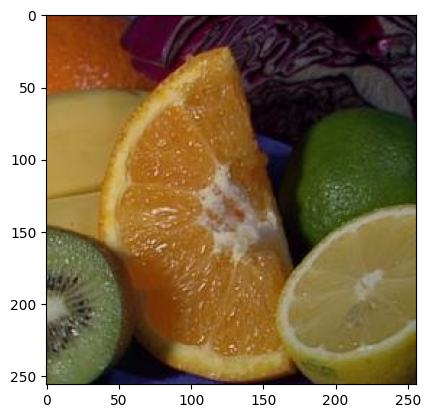

In [13]:
e = Encryption(image)
r,g,b = e.matrices()

### 1. intermix

In [14]:
start_time = time.time()
rd = e.InterMix(r,g,b)
gd = e.InterMix(g,rd,b)
bd = e.InterMix(b,rd,gd)
end_time = time.time()
time_records.append(round(end_time - start_time, 2))
# save_inter_image(image_name,step="intermix", rgb_flag=True, r=rd, g=gd, b=bd)

### 1.2 Mixrows

In [15]:
start_time = time.time()
mr,mg,mb = e.mixRows(rd,gd,bd,IVf)
end_time = time.time()
time_records.append(round(end_time - start_time, 2))
# save_inter_image(image_name, step="mixrows", rgb_flag=True, r=mr, g=mg, b=mb)

### 2. ACM

In [16]:
start_time = time.time()
acmR,acmG,acmB = e.applyACM_numba(mr,mg,mb)
end_time = time.time()
time_records.append(round(end_time - start_time, 2))
# save_inter_image(image_name, step="acm", rgb_flag=True, r=acmR, g=acmG, b=acmB)

Applying ACM 2.0...
m= 256, n= 256,
N(length of side) = 256,
alpha(number of squares) = 1,
L(an extra length) = 0,
eta(length of overlapping except last) = 256, k = 127.


### 3. Spiral Mixing

In [17]:
start_time = time.time()
smr = e.SpiralMixing(acmR)
smg = e.SpiralMixing(acmG)
smb = e.SpiralMixing(acmB)
end_time = time.time()
time_records.append(round(end_time - start_time, 2))
# save_inter_image(image_name, step="spiralmixing", rgb_flag=True, r=smr, g=smg, b=smb)

### 4. Encoding

In [18]:
start_time = time.time()
ecdR = e.Encoding(smr,rm1)
ecdG = e.Encoding(smg,rm1)
ecdB = e.Encoding(smb,rm1)
end_time = time.time()
time_records.append(round(end_time - start_time, 2))

### 5. Substitution

In [19]:
start_time = time.time()
subR = e.Substitution(ecdR,dsm,rm3)
subG = e.Substitution(ecdG,dsm,rm3)
subB = e.Substitution(ecdB,dsm,rm3)
end_time = time.time()
time_records.append(round(end_time - start_time, 2))

### 6. Decoding

In [20]:
start_time = time.time()
decR = e.Decoding(subR,rm4)
decG = e.Decoding(subG,rm4)
decB = e.Decoding(subB,rm4)
end_time = time.time()
time_records.append(round(end_time - start_time, 2))

In [21]:
cr = e.toMatrix(decR)
cg = e.toMatrix(decG)
cb = e.toMatrix(decB)

## final cipher image

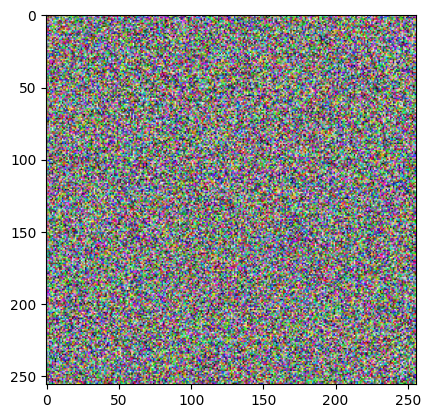

In [22]:
cipher = e.getFinalCipherImage(cr,cg,cb)

In [23]:
directory = f"./outputs/{image_name}"
os.makedirs(directory, exist_ok=True)  # Ensure directory exists

file_path = os.path.join(directory, f"{image_name}_cipher.png")
success = cv2.imwrite(file_path, cipher)
if success:
    print(f"Image saved successfully at {file_path}")
else:
    print("Failed to save image. Check if the image is valid.")

Image saved successfully at ./outputs/fruits/fruits_cipher.png


# Decryption


In [24]:
d = Decryption(cipher)

Displaying the pixel matrices over the Image


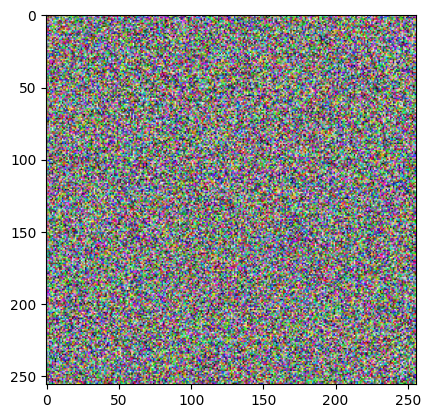

In [25]:
dr,dg,db = d.matrices()

### 1. Reverse Encoding

In [26]:
dencr,dencg,dencb = d.encoding(dr,dg,db,rm4)

### 2. Reverse Substitution

In [27]:
dsubr,dsubg,dsubb = d.revSubstitution(dencr,dencg,dencb,dsm,rm3)

### 3. Reverse Decoding

In [28]:
ddecr,ddecg,ddecb = d.decoding(dsubr,dsubg,dsubb,rm1)

In [29]:
ddecr = d.toMatrix(ddecr)
ddecg = d.toMatrix(ddecg)
ddecb = d.toMatrix(ddecb)

### 4. Reverse Spiral Mixing

In [30]:
dsmr,dsmg,dsmb = d.revSpiralMixing(ddecr,ddecg,ddecb)

### 5. Reverse ACM

In [31]:
dacmr,dacmg,dacmb = d.applyRevACM_numba(dsmr,dsmg,dsmb)

m= 256, n= 256,
N(length of side) = 256,
alpha(number of squares) = 1,
L(an extra length) = 0,
eta(length of overlapping except last) = 256, k = 127.


### 6.1 Rev Mixrows

In [32]:
rmrr = d.rmixRow(dacmr,IVf)
rmrg = d.rmixRow(dacmg,IVf)
rmrb = d.rmixRow(dacmb,IVf)

### 6. Reverse Intermix

In [33]:
rrev,grev,brev = d.revInterMix(rmrr,rmrg,rmrb)

## final decoded image

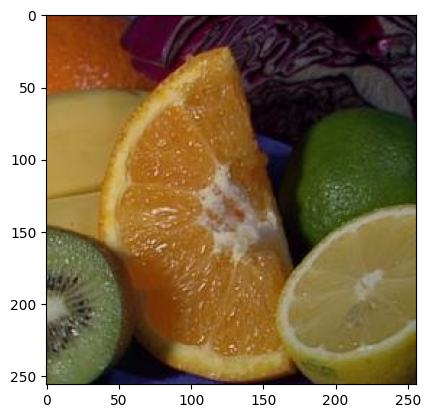

In [34]:
decodeCipher = d.getDecodedImage(rrev,grev,brev)

In [35]:
directory = f"./outputs/{image_name}/{image_name}_decrypted.png"
cv2.imwrite(directory, decodeCipher)

True

### checking pixel difference in original,cipher and decoded image

In [36]:
x.checkDiff(r,cr) #original red and cipher red
x.checkDiff(r,rrev) #original red and decoded red

The difference in pixels of the two images is  65264
The difference in pixels of the two images is  0


# Experimental results and analysis

In [37]:
directory = f"./outputs/{image_name}"
ex = experimentalAnalysis(cipher, directory)

m,n: 256 256


## histogram analysis

Histogram saved successfully at ./outputs/fruits/org_img_histogram.png


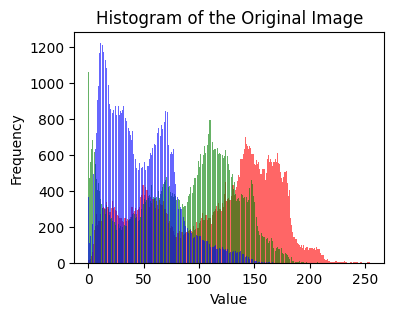

In [38]:
ex.plotHistogram(r,g,b,256, name="org_img_histogram")

Histogram saved successfully at ./outputs/fruits/cipher_img_histogram.png


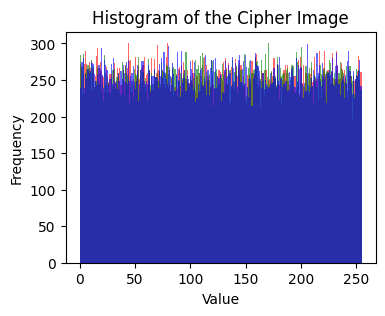

In [39]:
ex.plotHistogram(cr,cg,cb,256, name="cipher_img_histogram")

### variance

In [40]:
vr = ex.variance_numba(r)
vg = ex.variance_numba(g)
vb = ex.variance_numba(b)

vdr = ex.variance_numba(cr)
vdg = ex.variance_numba(cg)
vdb = ex.variance_numba(cb)

In [41]:
print("var of red",vr)
print("var of green",vr)
print("var of blue",vr)
print("var of cipher red",vdr)
print("var of cipher green",vdg)
print("var of cipher blue",vdb)

var of red 3090.297
var of green 3090.297
var of blue 3090.297
var of cipher red 5491.023
var of cipher green 5460.184
var of cipher blue 5478.391


### chi square

In [42]:
print("Chi Square of Cipher Red  ",ex.chiSquare(cr))
print("Chi Square of Cipher Green",ex.chiSquare(cg))
print("Chi Square of Cipher Blue ",ex.chiSquare(cb))

Chi Square of Cipher Red   265.5703125
Chi Square of Cipher Green 235.359375
Chi Square of Cipher Blue  256.5078125


### entropy


In [43]:
eRed = ex.entropy(r)
eGreen = ex.entropy(g)
eBlue = ex.entropy(b)
cRed = ex.entropy(cr)
cGreen = ex.entropy(cg)
cBlue = ex.entropy(cb)

In [44]:
import pandas as pd
columns = ["Original Red", "Original Blue", "Original Green","Cipher Red", "Cipher Blue", "Cipher Green"]
entropy = pd.DataFrame(columns=columns)
row = [eRed,eGreen,eBlue,cRed,cGreen,cBlue]

entropy = pd.concat([entropy, pd.DataFrame([row], columns=entropy.columns)], ignore_index=True)
entropy.index = ['Entropy of Lenna Image']
entropy

/var/folders/96/rrpmxf156gs2hjl259c_c07c0000gp/T/ipykernel_48907/2324934964.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  entropy = pd.concat([entropy, pd.DataFrame([row], columns=entropy.columns)], ignore_index=True)


,Original Red,Original Blue,Original Green,Cipher Red,Cipher Blue,Cipher Green
Entropy of Lenna Image,7.552131,7.337591,6.745963,7.997068,7.997395,7.997177


### correlation analysis

In [45]:
import numpy as np 
print('horizontal')
print('=======red========\n',ex.corAnalysisH(r))
print('\n=======green========\n',ex.corAnalysisH(g))
print('\n=======blue========\n',ex.corAnalysisH(b))
print('\n')
print('=======cipher red========\n',ex.corAnalysisH(cr))
print('\n=======cipher green========\n',ex.corAnalysisH(cg))
print('\n=======cipher blue========\n',ex.corAnalysisH(cb))

horizontal
=======red========
 0.9762509732695639

=======green========
 0.9341597993732424

=======blue========
 0.8754391077423433


=======cipher red========
 0.012642174611294424

=======cipher green========
 0.00837660251179246

=======cipher blue========
 0.007650086031180359


In [46]:
print('vertical')
print('=======red========\n',ex.corAnalysisV(r))
print('\n=======green========\n',ex.corAnalysisV(g))
print('\n=======blue========\n',ex.corAnalysisV(b))
print('\n')
print('=======cipher red========\n',ex.corAnalysisV(cr))
print('\n=======cipher green========\n',ex.corAnalysisV(cg))
print('\n=======cipher blue========\n',ex.corAnalysisV(cb))

vertical
=======red========
 0.9635233504858969

=======green========
 0.954775722679044

=======blue========
 0.9337957302718319


=======cipher red========
 0.00028831290303981874

=======cipher green========
 -0.007099925897869721

=======cipher blue========
 0.005983401054322331


In [47]:
print("diagonal\n")
print('=======red========\n',ex.corAnalysisD(r))
print('\n=======green========\n',ex.corAnalysisD(g))
print('\n=======blue========\n',ex.corAnalysisD(b))
print('\n')
print('=======cipher red========\n',ex.corAnalysisD(cr))
print('\n=======cipher green========\n',ex.corAnalysisD(cg))
print('\n=======cipher blue========\n',ex.corAnalysisD(cb))

diagonal

=======red========
 1.00120554871767

=======green========
 0.9425772323774219

=======blue========
 0.9551040876941886


=======cipher red========
 0.0049724041560627345

=======cipher green========
 -0.026686277883191348

=======cipher blue========
 0.02276330500153678


## NPCR and UACI

In [54]:
br=r.copy()
bg=g.copy()
bb=b.copy()
print(br[128][128],bg[128][128],bb[128][128])


br[128][128] = 117-32
bg[128][128] = 86-64
bb[128][128] = 55-32
print(br[128][128],bg[128][128],bb[128][128])

117 86 55
85 22 23


Applying Algorithm Steps one by one

Steps 1: Inter channel Mixing

Step 2: applying Mixrows

Step 3: applying ACM algorithm

Applying ACM 2.0...
m= 256, n= 256,
N(length of side) = 256,
alpha(number of squares) = 1,
L(an extra length) = 0,
eta(length of overlapping except last) = 256, k = 127.

Step 4: applying spiral mixing 

Step 5: applying Encoding

Step 6: applying Substitution

Step 7: applying Decoding


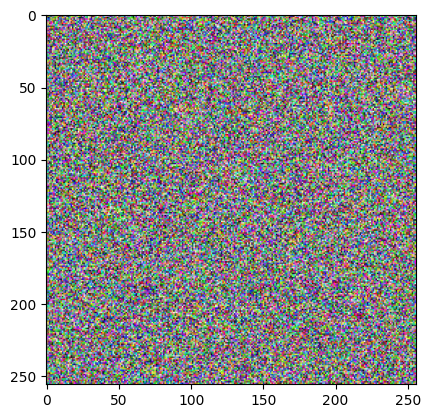

In [55]:
imaged = cv2.merge((bb,bg,br))
start_time = time.time()
cipherd = e.applyEncryption(imaged, IVf, rm1, rm3, rm4, dsm)
end_time = time.time()
time_records.append(round(end_time - start_time, 2))

In [56]:
cbd,cgd,crd = cv2.split(cipherd)

In [57]:
print("=====NPCR======")
print(npcr(cr,crd))
print(npcr(cg,cgd))
print(npcr(cb,cbd))

print("=====UACI=====")
print(uaci(cr,crd))
print(uaci(cg,cgd))
print(uaci(cb,cbd))

=====NPCR======
99.23858642578125
99.60174560546875
99.60174560546875
=====UACI=====
33.539925369561885
33.614705403645836
33.58118992225796


## PSNR

In [67]:
am,an,p = image.shape
def noiceAttack(image):
    for i in range(0,int(am/2)):
        for j in range(0,int(an/2)):
            image[i][j] = 1
    return image

In [68]:
pr = cr.copy()
pg = cg.copy()
pb = cb.copy()

pr = noiceAttack(pr)
pg = noiceAttack(pg)
pb = noiceAttack(pb)

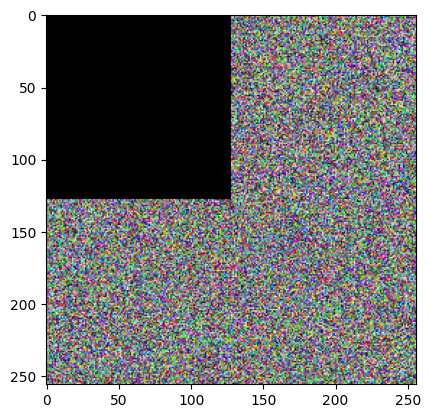

In [69]:
import matplotlib.pyplot as plt
prgb = np.dstack((pr,pg,pb))
plt.imshow(prgb)
plt.show()
Prgb = cv2.merge((pb,pg,pr))

In [70]:
import os
psnr_directory = f"./outputs/occlusion/{image_name}"
os.makedirs(psnr_directory, exist_ok=True)  # Ensure directory exists

file_path = os.path.join(psnr_directory, f"{image_name}_noise_attack.png")
success = cv2.imwrite(file_path, Prgb)
if success:
    print(f"Image saved successfully at {file_path}")
else:
    print("Failed to save image. Check if the image is valid.")

Image saved successfully at ./outputs/occlusion/fruits/fruits_noise_attack.png


Applying Decryption Algorithm on provided image

Step 1: applying Encoding

Step 2: applying Reverse Substitution

Step 3: applying Decoding

Step 4: applying reverse spiral mixing

Step 5: applying reverse ACM algorithm

m= 256, n= 256,
N(length of side) = 256,
alpha(number of squares) = 1,
L(an extra length) = 0,
eta(length of overlapping except last) = 256, k = 127.

Step 6: applying reverse mixrows


Step 7: applying reverse Intermix



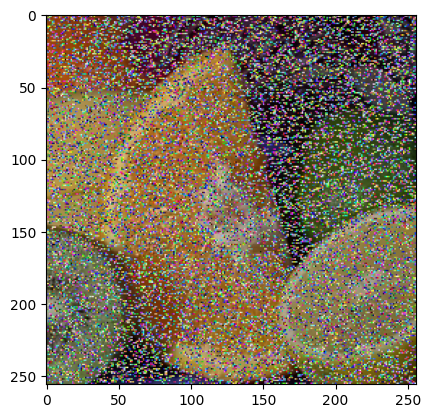

In [71]:
print("Applying Decryption Algorithm on provided image\n")
pb,pg,pr = cv2.split(Prgb)
print("Step 1: applying Encoding\n")
enR,enG,enB = d.encoding(pr,pg,pb,rm4)
print("Step 2: applying Reverse Substitution\n")
rsR,rsG,rsB = d.revSubstitution(enR,enG,enB,dsm,rm3)
print("Step 3: applying Decoding\n")
dcR,dcG,dcB = d.decoding(rsR,rsG,rsB,rm1)
fred = d.toMatrix(dcR)
fgreen = d.toMatrix(dcG)
fblue = d.toMatrix(dcB)
print("Step 4: applying reverse spiral mixing\n")
mixR,mixG,mixB = d.revSpiralMixing(fred,fgreen,fblue)
print("Step 5: applying reverse ACM algorithm\n")
acmR,acmG,acmB = d.applyRevACM_numba(mixR,mixG,mixB)
print("\nStep 6: applying reverse mixrows\n")
mrr,mrg,mrb = d.revmixRows(acmR,acmG,acmB,IVf)
print("\nStep 7: applying reverse Intermix\n")
mrR,mrG,mrB = d.revInterMix(mrr,mrg,mrb)
decodedImage = d.getDecodedImage(mrR,mrG,mrB)

In [72]:
decodedImage = cv2.merge((mrB,mrG,mrR))
file_path = os.path.join(psnr_directory, f"{image_name}_decrypted.png")
success = cv2.imwrite(file_path, decodedImage)
if success:
    print("success saved at",file_path)
else:
    print("unable to save")

success saved at ./outputs/occlusion/fruits/fruits_decrypted.png


In [73]:
import math
def calculate_PSNR(original_image, cipher_image):
    MSE=0
    m=n=256
    for i in range(0,m):
        row=0
        for j in range(0,n):
             row = row + ((original_image[i][j] - cipher_image[i][j])**2)
        MSE = MSE + row
    MSE = MSE/(m*n)
    
    # Calculate PSNR in decibels
    PSNR = 10 * math.log10((255*255)/MSE)
    return PSNR

In [74]:
import warnings
warnings.filterwarnings("ignore")
print(calculate_PSNR(r,mrR))
print(calculate_PSNR(g,mrG))
print(calculate_PSNR(b,mrB))

8.24267763858359
8.233851572038212
8.258961234166938


In [571]:
step_names = [
    "intermix",
    "mix_rows",
    "ACM",
    "spiral_mixing",
    "encoding",
    "substitution",
    "decoding",
    "total_time",
]

if not time_df.empty and image_name in time_df["image"].values:
    print(f"Image '{image_name}' already exists. Skipping...")
else:
    # Create a new row
    size = image.shape[0]
    row = {"image": image_name, "size": size}
    if len(time_records)<10:
        time_records.append(round(sum(time_records), 2))
    for step_name, time_value in zip(step_names, time_records):
        row[step_name] = time_value
    # row["total_time_in_sec"] = round(sum(time_records),3)

    # Append and save
    df_time = pd.concat([time_df, pd.DataFrame([row])], ignore_index=True)
    df_time.to_csv('./outputs/time_complexity.csv', index=False)
    print(f"Saved timing for image '{image_name}'.")

Saved timing for image 'fruits1024'.
